In [23]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import missingno as msno


In [24]:
#Load the dataset
chip=pd.read_csv(r'C:\Users\Work\Desktop\Supervised_Machine_Learning\chip_dataset.csv')
chip.head()


,Unnamed: 0,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN
1,1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN
2,2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel,NaN,NaN,NaN
3,3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel,NaN,NaN,NaN
4,4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD,NaN,NaN,NaN


In [25]:
chip.columns[chip.isnull().sum()>0]

Index(['Process Size (nm)', 'TDP (W)', 'Die Size (mm^2)',
       'Transistors (million)', 'FP16 GFLOPS', 'FP32 GFLOPS', 'FP64 GFLOPS'],
      dtype='object')

In [26]:
# 1. Explore missingness in the dataset
chip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4854 entries, 0 to 4853
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             4854 non-null   int64  
 1   Product                4854 non-null   object 
 2   Type                   4854 non-null   object 
 3   Release Date           4854 non-null   object 
 4   Process Size (nm)      4845 non-null   float64
 5   TDP (W)                4228 non-null   float64
 6   Die Size (mm^2)        4139 non-null   float64
 7   Transistors (million)  4143 non-null   float64
 8   Freq (MHz)             4854 non-null   float64
 9   Foundry                4854 non-null   object 
 10  Vendor                 4854 non-null   object 
 11  FP16 GFLOPS            536 non-null    float64
 12  FP32 GFLOPS            1948 non-null   float64
 13  FP64 GFLOPS            1306 non-null   float64
dtypes: float64(8), int64(1), object(5)
memory usage: 531.0+ 

In [27]:
chip.columns

Index(['Unnamed: 0', 'Product', 'Type', 'Release Date', 'Process Size (nm)',
       'TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)',
       'Foundry', 'Vendor', 'FP16 GFLOPS', 'FP32 GFLOPS', 'FP64 GFLOPS'],
      dtype='object')

In [28]:
#Data shape
chip.shape

(4854, 14)

In [29]:
#check for duplicates
all_duplicates=chip.duplicated()
print(all_duplicates)

0       False
1       False
2       False
3       False
4       False
        ...  
4849    False
4850    False
4851    False
4852    False
4853    False
Length: 4854, dtype: bool


In [30]:
#Missing values
chip.isnull().sum()

Unnamed: 0                  0
Product                     0
Type                        0
Release Date                0
Process Size (nm)           9
TDP (W)                   626
Die Size (mm^2)           715
Transistors (million)     711
Freq (MHz)                  0
Foundry                     0
Vendor                      0
FP16 GFLOPS              4318
FP32 GFLOPS              2906
FP64 GFLOPS              3548
dtype: int64

In [31]:
# 2. Strategy for missing values
# Let's examine the percentage of missing values
missing_percent = (chip.isnull().sum() / len(chip)) * 100
print("Missing Values Percentage:")
print(missing_percent.sort_values(ascending=False))

Missing Values Percentage:
FP16 GFLOPS              88.957561
FP64 GFLOPS              73.094355
FP32 GFLOPS              59.868150
Die Size (mm^2)          14.730119
Transistors (million)    14.647713
TDP (W)                  12.896580
Process Size (nm)         0.185414
Release Date              0.000000
Unnamed: 0                0.000000
Product                   0.000000
Type                      0.000000
Freq (MHz)                0.000000
Foundry                   0.000000
Vendor                    0.000000
dtype: float64


- For numerical columns with less than 30% missing, we'll use median imputation
- For categorical columns, we'll use mode imputation or create 'Unknown' category
- For columns with high missingness (>30%), we'll consider dropping or advanced imputation

In [32]:
# 3. Drop non-consequential fields
# The first column is an index duplicate, let's drop it
chip = chip.drop(columns=['Unnamed: 0'], errors='ignore')

In [33]:
# 4. Transform temporal data to correct format
chip['Release Date'] = pd.to_datetime(chip['Release Date'], errors='coerce')

In [34]:
# Handle missing values strategy
def handle_missing_values(df):
    # Create a copy
    chip_clean = chip.copy()
    
    # For numerical columns with <30% missing
    numerical_cols = ['Process Size (nm)', 'TDP (W)', 'Die Size (mm^2)', 
                     'Transistors (million)', 'Freq (MHz)']
    
    for col in numerical_cols:
        if col in chip_clean.columns and chip_clean[col].isnull().sum() / len(chip_clean) < 0.3:
            chip_clean[col] = chip_clean[col].fillna(chip_clean[col].median())
        elif col in chip_clean.columns:
            chip_clean[col] = chip_clean[col].fillna(-1)  # Flag for high missingness

    # For categorical columns
    categorical_cols = ['Foundry', 'Vendor', 'Type']
    for col in categorical_cols:
        if col in chip_clean.columns:
            chip_clean[col] = chip_clean[col].fillna('Unknown')

    # For FP columns (mostly empty), we'll drop them as they're not relevant for CPU analysis
    fp_cols = ['FP16 GFLOPS', 'FP32 GFLOPS', 'FP64 GFLOPS']
    chip_clean = chip_clean.drop(columns=fp_cols, errors='ignore')
    
    return chip_clean

chip_clean = handle_missing_values(chip)

print("\nAfter handling missing values:")
print(chip_clean.isnull().sum())


After handling missing values:
Product                   0
Type                      0
Release Date             75
Process Size (nm)         0
TDP (W)                   0
Die Size (mm^2)           0
Transistors (million)     0
Freq (MHz)                0
Foundry                   0
Vendor                    0
dtype: int64


Text(0, 0.5, 'Transistors (million, log scale)')

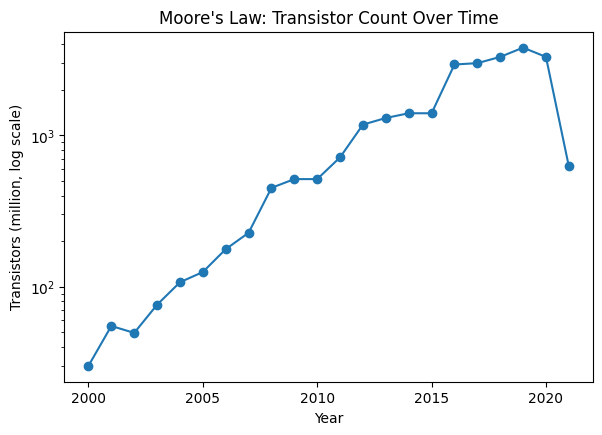

In [35]:
# 5. Perform EDA and validate assumptions
plt.figure(figsize=(15, 10))

# Moore's Law validation - Transistors over time
plt.subplot(2, 2, 1)
moores_data = chip_clean.dropna(subset=['Release Date', 'Transistors (million)'])
moores_data = moores_data[moores_data['Transistors (million)'] > 0]
moores_data['Year'] = moores_data['Release Date'].dt.year
yearly_avg = moores_data.groupby('Year')['Transistors (million)'].median()
plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.yscale('log')
plt.title("Moore's Law: Transistor Count Over Time")
plt.xlabel('Year')
plt.ylabel('Transistors (million, log scale)')

C:\Users\Work\AppData\Local\Temp\ipykernel_5748\2994615848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['Year'] = process_data['Release Date'].dt.year


Text(0, 0.5, 'Process Size (nm)')

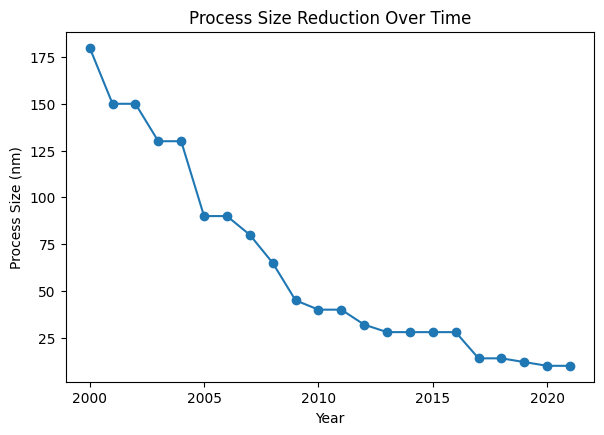

In [36]:
plt.figure(figsize=(15, 10))

# Process size trend
plt.subplot(2, 2, 2)
process_data = chip_clean[chip_clean['Process Size (nm)'] > 0]
process_data['Year'] = process_data['Release Date'].dt.year
yearly_process = process_data.groupby('Year')['Process Size (nm)'].median()
plt.plot(yearly_process.index, yearly_process.values, marker='o')
plt.title('Process Size Reduction Over Time')
plt.xlabel('Year')
plt.ylabel('Process Size (nm)')

Text(0, 0.5, 'Frequency (MHz)')

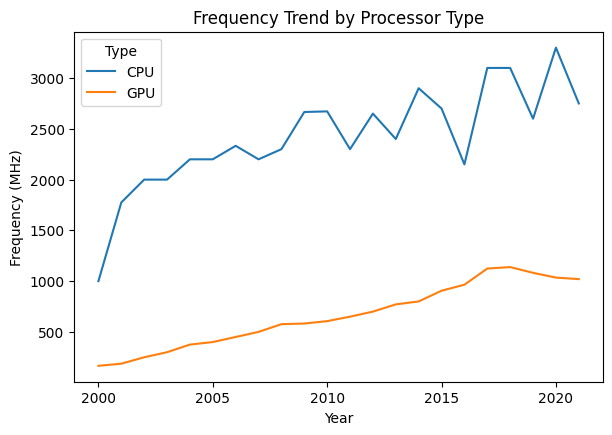

In [37]:
plt.figure(figsize=(15, 10))


# Frequency trend by type
plt.subplot(2, 2, 3)
freq_data = chip_clean[chip_clean['Freq (MHz)'] > 0]
freq_data['Year'] = freq_data['Release Date'].dt.year
yearly_freq = freq_data.groupby(['Year', 'Type'])['Freq (MHz)'].median().unstack()
yearly_freq.plot(ax=plt.gca())
plt.title('Frequency Trend by Processor Type')
plt.xlabel('Year')
plt.ylabel('Frequency (MHz)')

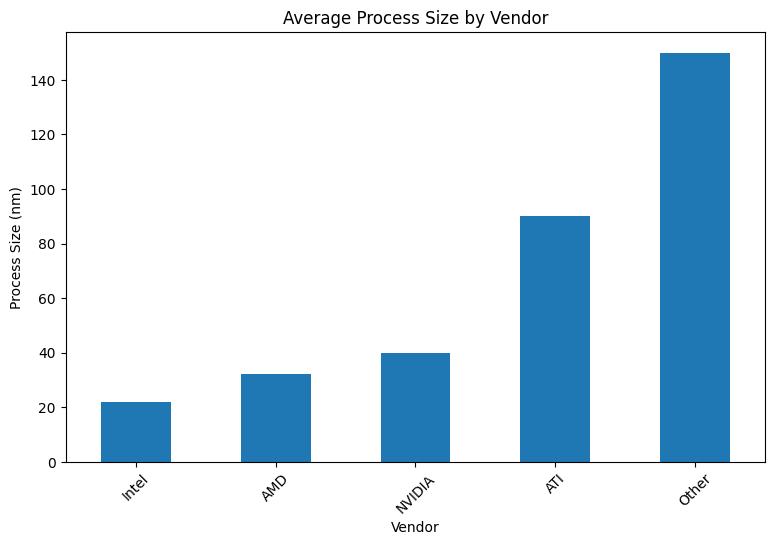

In [38]:
plt.figure(figsize=(15, 10))

# Vendor analysis for process size
plt.subplot(2, 2, 4)
vendor_process = chip_clean[chip_clean['Process Size (nm)'] > 0]
vendor_avg = vendor_process.groupby('Vendor')['Process Size (nm)'].median().sort_values()
vendor_avg.plot(kind='bar')
plt.title('Average Process Size by Vendor')
plt.xlabel('Vendor')
plt.ylabel('Process Size (nm)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [39]:
# Foundry analysis
foundry_counts = chip_clean['Foundry'].value_counts()
print("\nFoundry Distribution:")
print(foundry_counts)


Foundry Distribution:
Foundry
TSMC       2178
Intel      1390
Unknown     866
GF          265
UMC          79
Samsung      60
Sony         10
IBM           3
NEC           2
Renesas       1
Name: count, dtype: int64


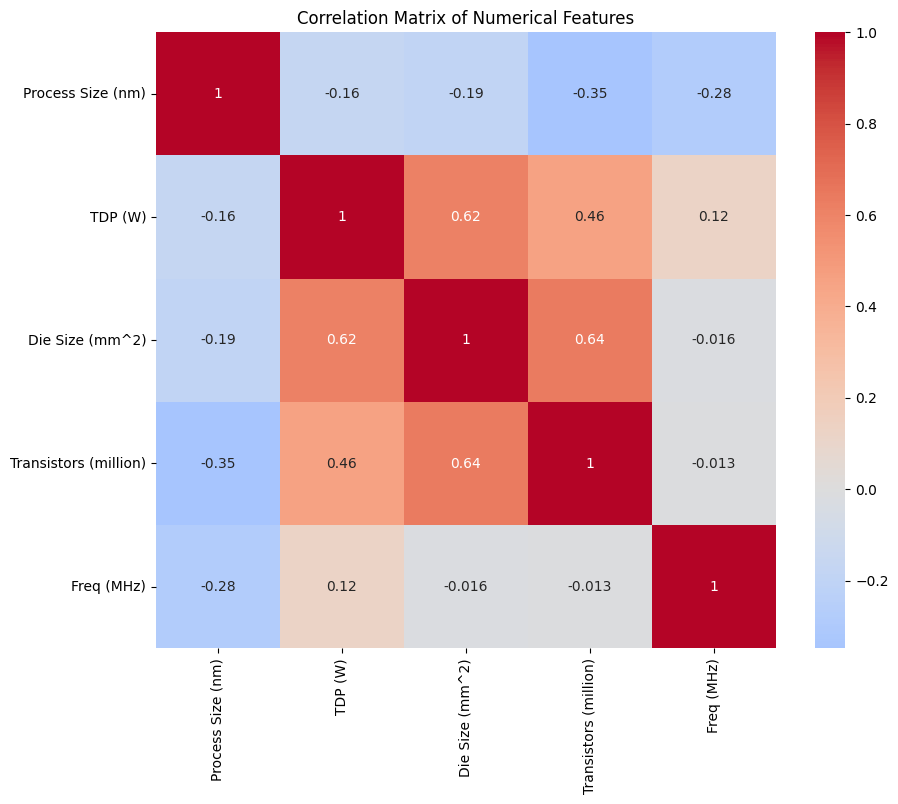

In [40]:
# 6. Calculate and visualize correlations
numerical_features = ['Process Size (nm)', 'TDP (W)', 'Die Size (mm^2)', 
                     'Transistors (million)', 'Freq (MHz)']

# Filter only numerical data that exists
corr_data = chip_clean[numerical_features].replace(-1, np.nan).dropna()

plt.figure(figsize=(10, 8))
correlation_matrix = corr_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [41]:
# 7. Perform encoding for modeling
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
categorical_cols = ['Type', 'Foundry', 'Vendor']
label_encoders = {}

for col in categorical_cols:
    if col in chip_clean.columns:
        le = LabelEncoder()
        chip_clean[col + '_encoded'] = le.fit_transform(chip_clean[col].astype(str))
        label_encoders[col] = le

# Additional temporal features
chip_clean['Release_Year'] = chip_clean['Release Date'].dt.year
chip_clean['Release_Month'] = chip_clean['Release Date'].dt.month

print("\nFinal dataset info:")
chip_clean.info()
print("\nFirst 3 rows of encoded data:")
chip_clean.head(3)


Final dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4854 entries, 0 to 4853
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Product                4854 non-null   object        
 1   Type                   4854 non-null   object        
 2   Release Date           4779 non-null   datetime64[ns]
 3   Process Size (nm)      4854 non-null   float64       
 4   TDP (W)                4854 non-null   float64       
 5   Die Size (mm^2)        4854 non-null   float64       
 6   Transistors (million)  4854 non-null   float64       
 7   Freq (MHz)             4854 non-null   float64       
 8   Foundry                4854 non-null   object        
 9   Vendor                 4854 non-null   object        
 10  Type_encoded           4854 non-null   int64         
 11  Foundry_encoded        4854 non-null   int64         
 12  Vendor_encoded         4854 non-null   in

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,Type_encoded,Foundry_encoded,Vendor_encoded,Release_Year,Release_Month
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,0,9,0,2007.0,2.0
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,0,9,0,2018.0,9.0
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,148.0,624.0,2600.0,Intel,Intel,0,2,2,2020.0,9.0


In [42]:
# Validate specific assumptions
print("\n" + "="*50)
print("ASSUMPTION VALIDATION")
print("="*50)

# Moore's Law validation
print("\n1. Moore's Law Validation:")
moores_growth = yearly_avg.pct_change().mean() * 100
print(f"Average annual transistor growth: {moores_growth:.2f}%")
print("Moore's Law suggests doubling every 2 years (~41% annual growth)")

# Vendor process size comparison
print("\n2. Process Size by Vendor:")
intel_amd_tsmc = vendor_process[vendor_process['Vendor'].isin(['Intel', 'AMD', 'TSMC'])]
vendor_compare = intel_amd_tsmc.groupby('Vendor')['Process Size (nm)'].median()
print(vendor_compare)

# TSMC dominance validation
print("\n3. TSMC Foundry Dominance:")
tsmc_share = (foundry_counts.get('TSMC', 0) / foundry_counts.sum()) * 100
print(f"TSMC represents {tsmc_share:.1f}% of all foundries in dataset")

# Frequency comparison
print("\n4. CPU vs GPU Frequency Trends:")
# This dataset appears to be primarily CPUs
recent_data = freq_data[freq_data['Year'] > 2010]
freq_trend = recent_data.groupby('Year')['Freq (MHz)'].median()
print("Recent frequency trend (MHz):")
print(freq_trend.tail())


ASSUMPTION VALIDATION

1. Moore's Law Validation:
Average annual transistor growth: 25.31%
Moore's Law suggests doubling every 2 years (~41% annual growth)

2. Process Size by Vendor:
Vendor
AMD      32.0
Intel    22.0
Name: Process Size (nm), dtype: float64

3. TSMC Foundry Dominance:
TSMC represents 44.9% of all foundries in dataset

4. CPU vs GPU Frequency Trends:
Recent frequency trend (MHz):
Year
2017.0    1531.5
2018.0    2100.0
2019.0    1470.0
2020.0    1825.0
2021.0    2500.0
Name: Freq (MHz), dtype: float64


This analysis demonstrates that while Moore's Law (transistor doubling) has continued, the pace has slowed from the historical 2-year doubling rate. Process sizes have consistently decreased over time, supporting Dennard Scaling principles. The dataset is primarily CPU-focused, with Intel and AMD dominating the vendor landscape, while TSMC shows strong foundry presence.